<p style="text-align: left; font-size: 32px; font-weight: bold;">
    Plotting custom variables for the HRRR using Herbie and Metpy and creating an animated GIF of the model run.
</p>

# Overview
### Within this notebook, we will cover:
#### 1. How to plot custom variables for the HRRR model using available variables and Metpy to calculate them. 
#### 2. This example will go over how to manually calculate theta-E (Equivalent Potential Temperature) and plot the values in a subset region.
#### 3. How to turn the model run into an animated GIF.

# Prerequisites 


| Concepts | Importance | Notes |
| -------- | ---------- | ----- |
| [Quickstart: Zero to Python](https://foundations.projectpythia.org/foundations/quickstart.html) | Required | For loops, lists |
| [Matplotlib Basics](https://link-to-matplotlib-basics) | Required | Basic plotting |
| [HRRR](https://herbie.readthedocs.io/en/stable/user_guide/tutorial/model_notebooks/hrrr.html#HRRR) | Required | Understanding of how to plot HRRR varables |
| [WGRIB2 Wrapper](https://herbie.readthedocs.io/en/stable/user_guide/tutorial/wgrib2-wrapper.html#%F0%9F%8E%81-Wrapper-for-wgrib2) | Optional (If you want to subset a region) | Understanding the subsetting function |
| [Herbie Inventory](https://herbie.readthedocs.io/en/stable/user_guide/tutorial/inventory.html#%F0%9F%93%83-Inventory) | Required | For understanding of how to access inventory variables to find what is needed to calculate the given parameter |
| [Metpy Calculations (mp.calc)](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html#module-metpy.calc) | Required | To understand how to calculate custom variables with metpy functions |
| [Metpy Basics](https://unidata.github.io/MetPy/latest/userguide/installguide.html#install-guide) | Required | To understand how MetPy works and how to install it |



* **Time to learn:** 40 Minutes


# Imports and setting a ms to kt conversion for winds.
#### Winds are measured in ms^-1 by default, but for practicality, we convert to kts.

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter
from PIL import Image
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
from herbie import Herbie, wgrib2
import matplotlib.colors as mcolors
import shutil
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Image as IPImage
%matplotlib inline


MS_TO_KNOTS = 1.94384

# Downsampling the data. 
#### Since the HRRR is a high resolution model with tight grid spacing, we want to smooth the data out so our plots are legible. 
The level of downsampling will be controlled by the "Step" variable

In [74]:
def downsample_data(data, step):
    return data[::step, ::step]

# Downloading and subetting the proper data

### Here we create a function that defines the files downloaded based on the date defined, the model defined (HRRR), the product (prs), the maximum forecast hour, and the extent that we want to subset for. 

A directory is created to place the downloaded files into temporarily, and then dictionaries for each filepath is created to append the subset file paths to the respective dictionaries based on the keys. This will also loop through the forecast hours and specifically set the variables searched for within the model data

In [77]:
def download_files(date, model, product, max_fxx, extent):
    base_dir = "downloaded_files"
    os.makedirs(base_dir, exist_ok=True)
    
    file_paths = {'surface': [], 'pressure': [], 'wind': [], 'wind2': [], 'cape': []}
    
    for fxx in range(max_fxx + 1):
        H = Herbie(date, model=model, product=product, fxx=fxx)
        ss_surface = ":2 m above ground"
        ss_pressure = ":surface"
        ss_wind = "UGRD:10 m above ground"
        ss_wind2 = "VGRD:10 m above ground"
        ss_cape = ":180-0 mb above ground"
        
        for var, key in zip([ss_surface, ss_pressure, ss_wind, ss_wind2, ss_cape], ['surface', 'pressure', 'wind', 'wind2', 'cape']):
            H.download(var)
            file_path = H.get_localFilePath(var)
            subset_file_path = wgrib2.region(file_path, extent, name=f"subset_{key}")
            file_paths[key].append(subset_file_path)
            
    return file_paths


# Creation of the frames and calculation of the variables

### Loading Data
This is where the MetPy function comes in as well. 
The filepaths for the given forecast hours are retrieved, then the datasets themselves are opened up and filtered by the keys so the proper data is loaded.

### Unit Conversion
The data is then extracted and converted to whatever units are needed (in this case, converted to degrees C and hPa), and the lat and lon are defined. (Please read the herbie inventory guide as sometimes the variable names in the Xarray dataset for the respective variables are different than the name in the inventory). 

### Theta-E Calculation
MetPy is used to calculate the Theta-E using surface pressure, 2m temp, and 2m dewpoint.

### 10 m Wind Calcuation
U and V winds at 10 m above the ground are used to calculate the 10 m winds.

### CAPE data extraction
See the relevant line

### Downsampling the data
We will downsample the data to prevent an overload of data being plotted. You can control the degree of downsampling with the step variables that will be at the end of the code. 

### Smoothing CAPE 
Since there is a lot of CAPE values that would be contoured, a gaussian filter is being applied to make the appearance and level of the data both visually appealing and adequate for proper analysis

### Plotting Code

The Theta-E is the filled contouring and is contoured at every 1 K. CAPE is contoured as lines and plotted at every 100 J/Kg. The barbs are also plotted with the ax.barb function. 

In [80]:
def create_frame(file_paths, fxx, output_dir, extent, step, barb_step):
    file_surface = file_paths['surface'][fxx]
    file_pressure = file_paths['pressure'][fxx]
    file_wind = file_paths['wind'][fxx]
    file_wind2 = file_paths['wind2'][fxx]
    file_cape = file_paths['cape'][fxx]
    
    #Opening the datasets
    ds_surface = xr.open_dataset(file_surface, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
    ds_pressure = xr.open_dataset(file_pressure, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
    ds_wind = xr.open_dataset(file_wind, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
    ds_wind2 = xr.open_dataset(file_wind2, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
    ds_cape = xr.open_dataset(file_cape, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
    
    #Conversion of variables to proper units
    t2m = ds_surface.t2m - 273.15  # Convert to Celsius
    d2m = ds_surface.d2m - 273.15  # Convert to Celsius
    surface_pressure = ds_pressure.sp / 100  # Convert to hPa
    lon = ds_surface.longitude
    lat = ds_surface.latitude
    
    # Calculate theta-e
    temperature = t2m.values * units.degC
    dewpoint = d2m.values * units.degC
    pressure = surface_pressure.values * units.hPa
    theta_e = mpcalc.equivalent_potential_temperature(pressure, temperature, dewpoint)
    theta_e = theta_e.to('K').magnitude  # Strip units for plotting
    
    #Calculation of 10 m wind
    u10 = ds_wind.u10.values * MS_TO_KNOTS
    v10 = ds_wind2.v10.values * MS_TO_KNOTS
    wind_speed = np.sqrt(u10**2 + v10**2)
    
    #Extraction of CAPE data
    mucape = ds_cape.cape
    
    # Downsample the data
    lon_ds = downsample_data(lon, step)
    lat_ds = downsample_data(lat, step)
    theta_e_ds = downsample_data(theta_e, step)
    u10_ds = downsample_data(u10, step)
    v10_ds = downsample_data(v10, step)
    mucape_ds = downsample_data(mucape, step)
    
    # Apply Gaussian filter to smooth the CAPE data
    mucape_ds_smoothed = gaussian_filter(mucape_ds, sigma=3)
    
    # Create the plot
    fig = plt.figure(figsize=[12, 8], dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Set the extents to zoom in on the region
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add states and other features
    ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    
    # Define levels for theta-e
    theta_e_levels = np.arange(np.min(theta_e_ds), np.max(theta_e_ds) + 1, 1)
    
    # Plot filled contours for theta-e
    contourf_theta_e = ax.contourf(
        lon_ds,
        lat_ds,
        theta_e_ds,
        levels=theta_e_levels,
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        alpha=0.7
    )
    
    # Add colorbar for theta-e with integer ticks
    cbar_theta_e = plt.colorbar(contourf_theta_e, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar_theta_e.set_label('Theta-E (K)')
    cbar_theta_e.locator = MaxNLocator(integer=True)  # Ensure integer ticks
    cbar_theta_e.update_ticks()
    
    # Define levels for MUCAPE
    cape_levels = np.arange(0, mucape_ds_smoothed.max() + 100, 100)
    
    # Plot contour lines for MUCAPE using the magma colormap
    cmap = plt.get_cmap('magma')
    contour_cape = ax.contour(
        lon_ds,
        lat_ds,
        mucape_ds_smoothed,
        levels=cape_levels,
        colors=[cmap(i / len(cape_levels)) for i in range(len(cape_levels))],
        linewidths=1.0,
        transform=ccrs.PlateCarree()
    )
    
    # Add contour labels for MUCAPE
    clabels = ax.clabel(contour_cape, inline=True, fontsize=8, fmt='%1.0f')
    
    # Remove contour labels outside the extent
    for label in clabels:
        x, y = label.get_position()
        lon_lat = ax.projection.transform_points(ccrs.PlateCarree(), np.array([x]), np.array([y]))
        if not (extent[0] <= lon_lat[0][0] <= extent[1] and extent[2] <= lon_lat[0][1] <= extent[3]):
            label.set_visible(False)
    
    # Plot 10 m wind barbs after other elements to ensure they are on top
    if len(lon_ds) > 3 and len(lat_ds) > 3:
        # Downsample further for barbs
        lon_barbs = downsample_data(lon_ds, barb_step)
        lat_barbs = downsample_data(lat_ds, barb_step)
        u10_barbs = downsample_data(u10_ds, barb_step)
        v10_barbs = downsample_data(v10_ds, barb_step)
        
        # Use MetPy's barb plotting
        ax.barbs(
            lon_barbs.values.flatten(),
            lat_barbs.values.flatten(),
            u10_barbs.flatten(),
            v10_barbs.flatten(),
            transform=ccrs.PlateCarree(),
            length=6
        )
    
    # Set the titles with forecast hour
    forecast_hour = ds_surface.time.dt.hour.item()  # Extract forecast hour from dataset time
    ax.set_title(
        f"Valid: {ds_surface.time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(f'Theta-E and MUCAPE with 10m Wind Barbs (Forecast Hour: {fxx})', loc="right")
    
    # Save the frame
    frame_filename = os.path.join(output_dir, f"frame_{fxx:02d}.png")
    plt.savefig(frame_filename, bbox_inches='tight')
    plt.close(fig)
    
    return frame_filename

# Function for the creation of the GIF from the created frames and clean up of frames and directory

Specify the directory path of the GRIB2 files and change the C:\\Users\\thewe\\data\\hrrr to whatever the path is on your local machine. It will likely be similar depending on how you configure your stuff to save

In [90]:
def create_animated_gif(date, model, product, max_fxx, output_gif, extent, step, barb_step):
    output_dir = "frames"
    os.makedirs(output_dir, exist_ok=True)
    
    # Download files
    file_paths = download_files(date, model, product, max_fxx, extent)
    
    frames = []
    for fxx in range(max_fxx + 1):
        frame_filename = create_frame(file_paths, fxx, output_dir, extent, step, barb_step)
        if frame_filename:
            frames.append(Image.open(frame_filename))
    
    # Save as GIF
    if frames:
        frames[0].save(
            output_gif,
            save_all=True,
            append_images=frames[1:],
            duration=500,  # duration in milliseconds
            loop=0
        )
    
    # Cleanup: remove frame files
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    # Remove downloaded files, subsets.
    for key in file_paths:
        for file_path in file_paths[key]:
            if os.path.exists(file_path):
                os.remove(file_path)
            # Also remove the original file and its idx file if they exist
            original_file_path = str(file_path).replace(f"subset_{key}_", "")
            if os.path.exists(original_file_path):
                os.remove(original_file_path)
    
    # Remove the directory named after the date inside the hrrr file
    date_dir = os.path.join("C:\\Users\\thewe\\data\\hrrr", date.split()[0].replace("-", ""))
    if os.path.exists(date_dir):
        for root, dirs, files in os.walk(date_dir, topdown=False):
            for name in files:
                os.remove(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(date_dir)
    
    # Optionally remove the frames directory if empty
    if not os.listdir(output_dir):
        os.rmdir(output_dir)

# Parameter settings and creation of GIF

Set your parameters to your liking and make your fancy GIF!

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Jun-16 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Jun-16 12:00 UTC F01 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Jun-16 12:00 UTC F02 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Jun-16 12:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Jun-16 12:00 UTC F04 ┊ GRIB2 @ aws ┊ IDX @ aws
Animated GIF saved as theta_e_mucape_wind_animation.gif


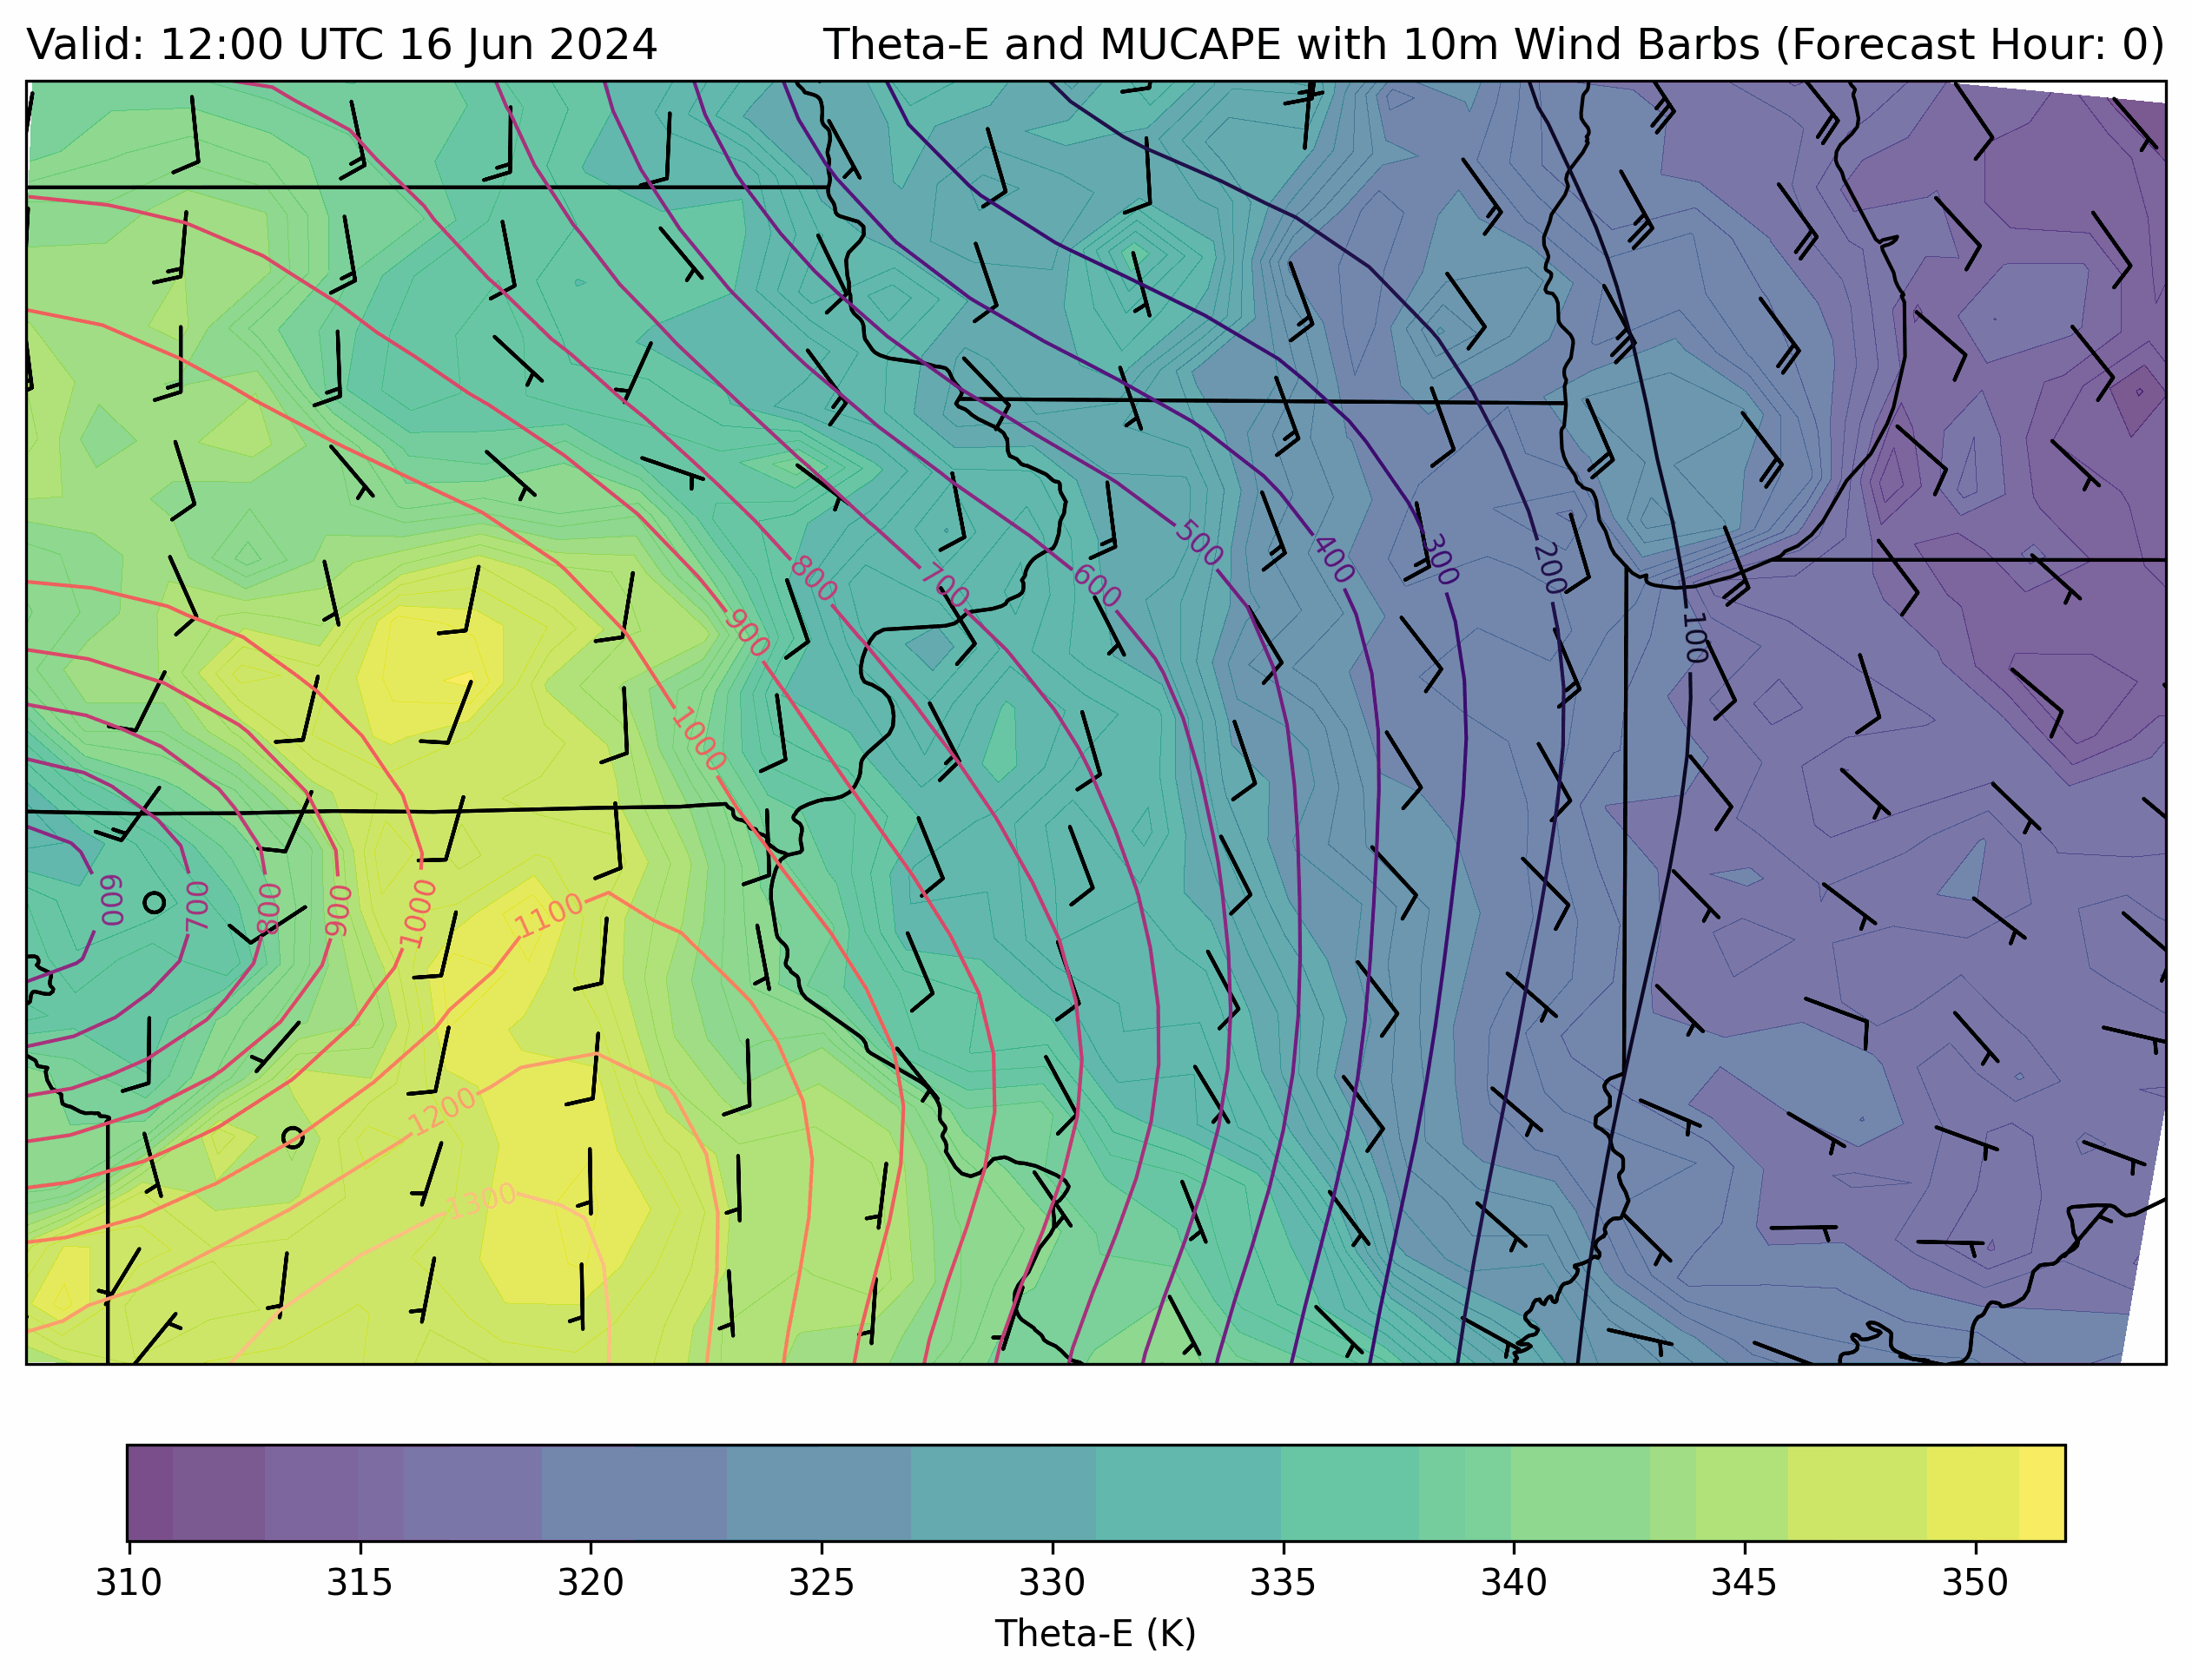

In [93]:
# Parameters
date = "2024-06-16 12:00"
model = "hrrr"
product = "prs"
max_fxx = 4  # Reduce the maximum forecast hour to reduce memory usage
output_gif = "theta_e_mucape_wind_animation.gif"
extent = (-95.0, -85.0, 38.0, 44.0)
step = 10  # Adjust step size for downsampling
barb_step = 2  # Adjust step size for wind barb density

# Create the animated GIF
create_animated_gif(date, model, product, max_fxx, output_gif, extent, step, barb_step)

print(f"Animated GIF saved as {output_gif}")

with open(output_gif, 'rb') as f:
    display(IPImage(data=f.read(), format='gif'))